In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import urllib.request
import tensorflow as tf
from PIL import Image
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
import numpy as np
from keras import backend
from tensorflow import keras
from tensorflow.python.keras.layers import Dense, Flatten
from glob import glob
import time
import random
import csv
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from joblib import Parallel, delayed

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
path = "gdrive/MyDrive/archive/*"
n_samples = 2000 # Testing with 5k images for time constraints
image_paths = glob(path)[:n_samples]

In [ ]:
height = 512
width = 512

# This function does all preprocessing needed
def preprocess(image_path):
  content_img = Image.open(image_path).resize((width, height))

  content_arr = np.asarray(content_img, dtype='float32')
  if len(content_arr.shape) < 3:
    content_arr = np.array([content_arr, content_arr, content_arr]).reshape(width, height, 3)
  
  content_arr = np.expand_dims(content_arr, axis=0)
  return content_arr

def sampling_inner(arr):
  a = np.random.rand(1)[0]
  x = (a-0.00001) // 0.25
  subset = arr[int(x)]
  
  b = np.random.rand(1)[0]
  if(b> 0.75):
    subset = np.random.randint(n_clusters)
    while(len(np.where(clusters == subset)) == 0):
      subset = np.random.randint(n_clusters)
  return subset
  
def sampling_outer(prev_votes):
  a = summ * np.random.rand(1)[0]
  sub = 0
  add = p
  for i in range(n):
    if(a < add):
      sub = sampling_inner(prev_votes[:,i])
      return sub      
    else:
      add+=p*alpha**i
  return sub

def iter(prev_votes, uvote):
  ##uvote is a array containing 4 subset number
  curr = [0]*4
  
  temp = np.zeros((4,n))
  temp[:,1:]=prev_votes[:,:-1]
  temp[:,0]= uvote
  prev_votes = temp
  for i in range(4):
    curr[i] = sampling_outer(prev_votes)
  return curr, prev_votes

def cluster_to_img(cluster):
  arr = np.where(clusters == cluster)[0]
  img_idx = random.choice(arr)
  return preprocess(image_paths[img_idx]).astype(int)[0]

In [ ]:
# VGG16 is used as pretrained CNN model
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(512, 512, 3))
model = keras.Sequential()

for layer in vgg_model.layers:
  model.add(layer)

model.add(Flatten())
model.add(Dense(512, name='embeddings'))
# layers = dict([(layer.name, layer.output) for layer in model.layers])

In [ ]:
from tqdm import tqdm
embeddings = np.zeros((n_samples, 512))

def create_embeddings(embeddings, i):
  # for i in tqdm(range(len(image_paths))):
  embeddings[i] = model.predict(preprocess(image_paths[i]))
  
  return embeddings

Parallel(n_jobs = -1, prefer='threads')(delayed(create_embeddings)(embeddings, i) for i in tqdm(range(len(image_paths)), position=0, leave=True))

# embeddings = np.loadtxt("gdrive/MyDrive/embeds.txt")
embeddings = np.squeeze(np.array(embeddings))
np.savetxt("embeds.txt", embeddings)


  1%|          | 19/2000 [00:41<1:11:35,  2.17s/it]

100%|██████████| 2000/2000 [03:04<00:00, 10.82it/s]


In [ ]:
from sklearn.metrics import silhouette_score

n_clusters = 40
# K = range(50, 200, 20)

km = KMeans(n_clusters=n_clusters).fit(embeddings)
# print(km.labels_.shape, embeddings.mean(axis=1).shape)

# sil1 = silhouette_score(km.labels_.reshape(-1, 1), embeddings.mean(axis=1).reshape(-1, 1), metric='euclidean')

# for k in tqdm(K):
#   km = KMeans(n_clusters=k).fit(embeddings)
#   sil2 = silhouette_score(km.labels_.reshape(-1, 1), embeddings.mean(axis=1).reshape(-1, 1), metric='euclidean')

#   if sil1 < sil2:
#     n_clusters = k

#   sil1 = sil2
#   print(n_clusters)

In [ ]:
clusters = np.zeros(n_samples)

for cluster in range(n_clusters):
  for image in np.where(km.labels_ == cluster):
    clusters[image] = cluster

# with open("imgs_clusters.csv", 'w') as csvfile:
#   writer = csv.writer(csvfile)
#   for i in range(n_samples):
#     writer.writerow([image_paths[i], clusters[i]])

Number of images in cluster 16 is  15


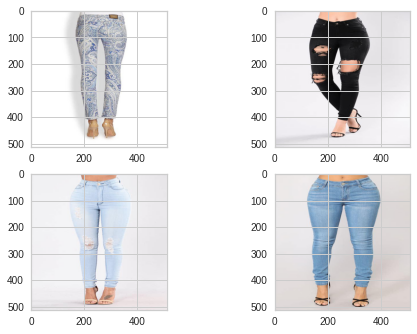

In [ ]:
# Testing the clusters manually 
cls = 16
lst = np.where(clusters == cls)[0]
print(f"Number of images in cluster {cls} is ", len(lst))
samples = [random.choice(lst), random.choice(lst), random.choice(lst), random.choice(lst)]

plt.subplot(2, 2, 1)
plt.imshow(preprocess(image_paths[samples[0]]).astype(int)[0])

plt.subplot(2, 2, 2)
plt.imshow(preprocess(image_paths[samples[1]]).astype(int)[0])

plt.subplot(2, 2, 3)
plt.imshow(preprocess(image_paths[samples[2]]).astype(int)[0])

plt.subplot(2, 2, 4)
plt.imshow(preprocess(image_paths[samples[3]]).astype(int)[0])

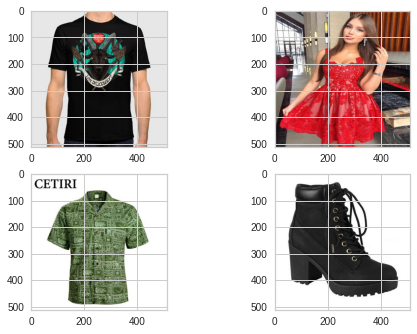

Enter your votes(1 for positive and -1 for negative): -1 -1 -1 1


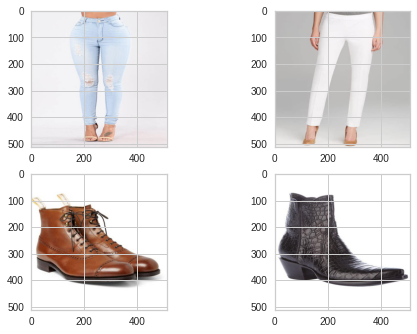

Enter your votes(1 for positive and -1 for negative): -1 -1 1 1


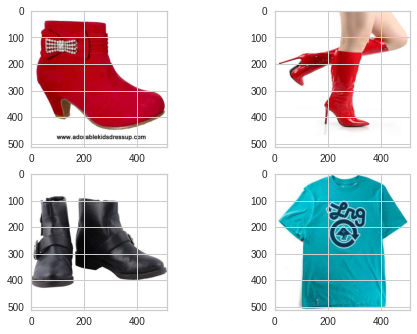

Enter your votes(1 for positive and -1 for negative): 1 1 1 -1


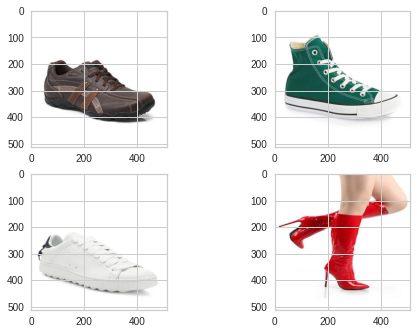

Enter your votes(1 for positive and -1 for negative): -1 -1 -1 -1


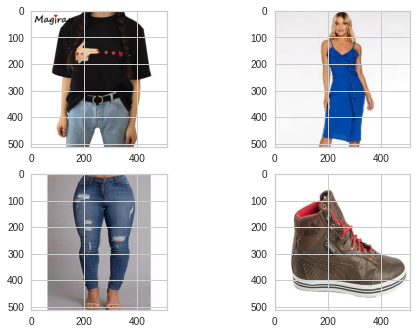

Enter your votes(1 for positive and -1 for negative): q


ValueError: ignored

In [ ]:
n = 5
alpha = 0.2
p = 0.8
summ = 0

for i in range(n):
  summ += p*(alpha**i)

prev_votes = np.floor(n_clusters*np.random.rand(4, n)-0.000001)
boundary = np.zeros(n)

uvote = np.random.randint(n_clusters,size=4)

while(1):
    plt.subplot(2,2,1)
    plt.imshow(cluster_to_img(uvote[0]))
    plt.subplot(2,2,2)
    plt.imshow(cluster_to_img(uvote[1]))
    plt.subplot(2,2,3)
    plt.imshow(cluster_to_img(uvote[2]))
    plt.subplot(2,2,4)
    plt.imshow(cluster_to_img(uvote[3]))
    plt.show()
    
    time.sleep(0.5)
    ip = list(map(int, input("Enter your votes(1 for positive and -1 for negative): ").split()))  

    uvote = np.array(ip) * uvote
    
    neg = (uvote < 0).sum()

    if neg == 4:
      uvote = np.random.randint(n_clusters,size=4)
    elif neg == 3:
      temp = uvote[uvote > 0][0]
      uvote = np.array([temp, temp, temp, temp])
    elif neg == 2:
      temp1 = uvote[uvote > 0][0]
      temp2 = uvote[uvote > 0][1]
      uvote = np.array([temp1, temp2, temp1, temp2])
    elif neg == 1:
      temp1 = uvote[uvote > 0][0]
      temp2 = uvote[uvote > 0][1]
      temp3 = uvote[uvote > 0][2]
      uvote = np.array([temp1, temp2, temp3, temp3])

    uvote, prev_votes = iter(prev_votes, uvote)